# 5C allele specific density plots

2/16/2021

create density plots from bam files for the allele specific atac density plots

In [1]:
import pandas as pd
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
save_dir  = 'vcf_files/atac/'

In [3]:
# we know ATAC reads are ~76 bp long so save matrix width should be 200 bp long just to be sfe
SAVE_WIDTH = 200
SNP_LOC_SAVE = 100 # 0 indexed

In [4]:
glob.glob(os.path.join(save_dir, '*sam'))

['vcf_files/atac/CXCL5_SLC_chr4_74864687.sam',
 'vcf_files/atac/PEMT_SLC_chr17_17942613.sam',
 'vcf_files/atac/PEMT_H9D2_chr17_17942613.sam',
 'vcf_files/atac/NFATC3_H9D2_chr16_68344945.sam',
 'vcf_files/atac/PEMT_H9D2_chr17_17897739.sam',
 'vcf_files/atac/BRINP1_H9D2_chr9_121358237.sam',
 'vcf_files/atac/BRINP1_SLC_chr9_121358237.sam',
 'vcf_files/atac/NFATC3_SLC_chr16_68344945.sam',
 'vcf_files/atac/RTN1_H9D2_chr14_60155307.sam']

# testing for PEMT_chr17_17942613.same 

In [5]:
def read_sam_density(sam_file):
    read_starts, seqs = [], []
    with open (sam_file, 'r') as f:
        lines = f.readlines()
        print(len(lines),'num lines')
        for line in lines:
            line = line.strip().split('\t')
            read_starts.append(int(line[3])) # 4th col: 1-based leftmost mapping POSition
            seqs.append(line[9]) # 10th col: seq
    return read_starts, seqs

In [6]:
def process_read(read_start, seq, snp_pos, snp_loc_save = SNP_LOC_SAVE):
    """
    need to get snp letter at location and start and end position
    return
        snp_letter ('A','C','T','G')
        int position of start
        int position of end (not inclusive)
    """
    if read_start + len(seq) <= snp_pos: # doesn't cover snp location too upstream
        return '',None,None
    elif read_start > snp_pos: # too downstream
        return '',None,None
    else:
#         print(snp_pos, read_start,snp_pos -read_start)
#         print(seq)
        snp_letter = seq[snp_pos -read_start]
        snp_loc_save_start = snp_loc_save- (snp_pos -read_start)
        return snp_letter, snp_loc_save_start, snp_loc_save_start + len(seq) 


PEMT chr17 17942613
520 num lines


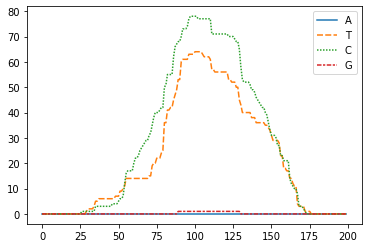

In [7]:
# testing
sam_file = 'vcf_files/atac/PEMT_H9D2_chr17_17942613.sam'
gene,tissue,chrom, pos = os.path.basename(sam_file).split('.')[0].split('_')
pos = int(pos)
print(gene,chrom, pos)
# read sam file
read_starts, seqs = read_sam_density(sam_file)
# initialzie density storage matrices
snp_to_info  = {}
for letter in ['A','T','C','G']:
    snp_to_info[letter] = np.zeros((len(read_starts),SAVE_WIDTH)) 
# get positions
for idx,(read_start, seq) in enumerate(zip(read_starts, seqs )):
    snp_letter, start_pos, end_pos = process_read(read_start, seq, pos)
    if snp_letter is not '':
        snp_to_info[snp_letter][idx,start_pos: end_pos] = 1
# make final data fram for plotting
snp_to_density = {}
for letter in ['A','T','C','G']:
    snp_to_density[letter]= snp_to_info[letter].sum(axis=0)
sns.lineplot(data=pd.DataFrame.from_dict(snp_to_density))

In [8]:
sns_plot_data = pd.DataFrame.from_dict(snp_to_density)
sns_plot_data[:5]

,A,T,C,G
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


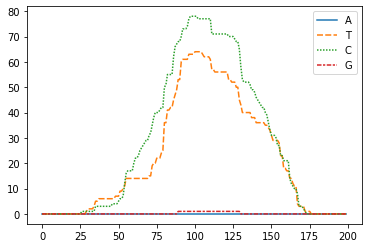

In [9]:
sns.lineplot(data = sns_plot_data)

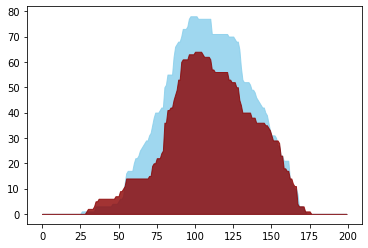

In [10]:
ref = 'C'
alt = 'T'
plt.figure()
plt.fill_between( sns_plot_data.index, sns_plot_data[ref].values, color="skyblue", alpha=0.8)
plt.fill_between( sns_plot_data.index, sns_plot_data[alt].values, color="darkred", alpha=0.8)
plt.show()

# 2. run though all sams

CXCL5 SLC chr4 74864687
71 num lines
PEMT SLC chr17 17942613
491 num lines
PEMT H9D2 chr17 17942613
520 num lines
NFATC3 H9D2 chr16 68344945
520 num lines
PEMT H9D2 chr17 17897739
105 num lines
BRINP1 H9D2 chr9 121358237
256 num lines
BRINP1 SLC chr9 121358237
44 num lines
NFATC3 SLC chr16 68344945
411 num lines
RTN1 H9D2 chr14 60155307
381 num lines


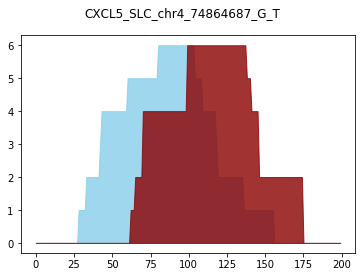

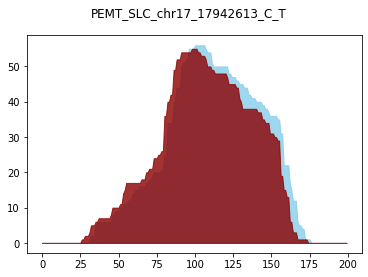

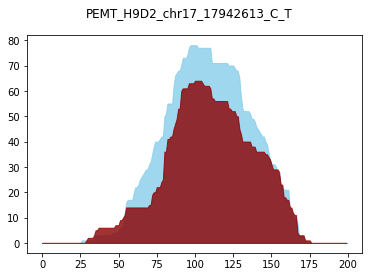

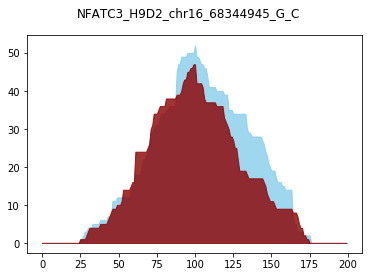

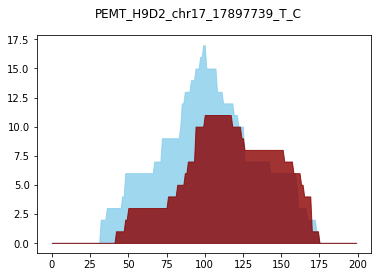

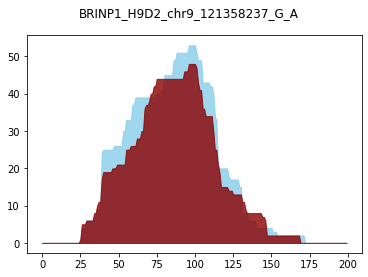

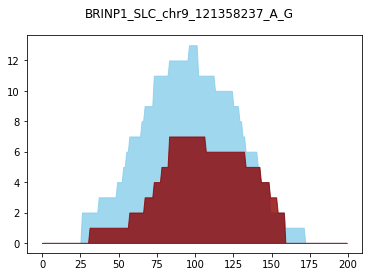

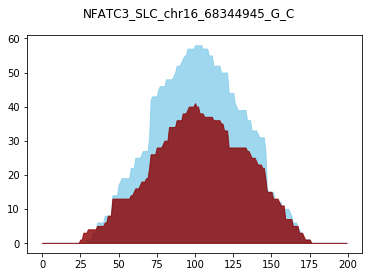

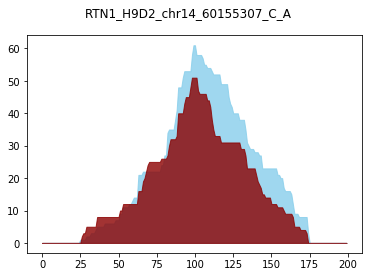

In [11]:
# testing
for sam_file in glob.glob(os.path.join(save_dir, '*sam')):
    gene,tissue,chrom, pos = os.path.basename(sam_file).split('.')[0].split('_')
    pos = int(pos)
    print(gene,tissue, chrom, pos)
    # read sam file
    read_starts, seqs = read_sam_density(sam_file)
    # initialzie density storage matrices
    snp_to_info  = {}
    for letter in ['A','T','C','G']:
        snp_to_info[letter] = np.zeros((len(read_starts),SAVE_WIDTH)) 
    # get positions
    for idx,(read_start, seq) in enumerate(zip(read_starts, seqs )):
        snp_letter, start_pos, end_pos = process_read(read_start, seq, pos)
        if snp_letter is not '':
            snp_to_info[snp_letter][idx,start_pos: end_pos] = 1
    # make final data frame for getting ref/alt
    snp_to_density = {}
    for letter in ['A','T','C','G']:
        snp_to_density[letter]= snp_to_info[letter].sum(axis=0)
    # assume ref = most, alt = 2nd most
    letter_order = pd.DataFrame(snp_to_density).sum(axis=0).sort_values().index
    ref, alt = letter_order[3], letter_order[2]
    snp_to_density_refalt = {
        alt:snp_to_density[alt],
        ref:snp_to_density[ref]
    }
    sns_plot_data = pd.DataFrame.from_dict(snp_to_density_refalt)
#     plt.figure()
#     sns.lineplot(data=sns_plot_data)
    fig = plt.figure()
    plt.fill_between( sns_plot_data.index, sns_plot_data[ref].values, color="skyblue", alpha=0.8)
    plt.fill_between( sns_plot_data.index, sns_plot_data[alt].values, color="darkred", alpha=0.8)
    title = '_'.join([gene,tissue, chrom, str(pos),ref,alt])
    fig.suptitle(title, fontsize=12)
    plt.savefig(os.path.join(save_dir,title+'.pdf'))
#         plt.show()
